In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

df = pd.read_csv('activities.csv')

df

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Media
0,7698835652,"Aug 25, 2022, 4:31:29 PM",80 degrees sunrise run,Run,NaN,743,2.27,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8146369281,"Nov 20, 2022, 8:12:07 PM",I am out of shape,Run,NaN,489,1.68,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8164065980,"Nov 24, 2022, 8:33:42 PM",Lunch Trail Run,Run,Better,481,1.68,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8207833156,"Dec 4, 2022, 6:26:38 PM",Snow,Run,NaN,1350,4.20,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8232903442,"Dec 10, 2022, 7:06:52 PM",Elevation,Run,NaN,1219,3.71,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,11529042773,"May 29, 2024, 10:42:16 PM",Afternoon Run,Run,NaN,3267,8.44,NaN,NaN,False,...,NaN,NaN,NaN,6568.0,NaN,NaN,468.0,229.0,3.430631,NaN
242,11543386850,"May 31, 2024, 10:35:59 PM",Afternoon Run,Run,NaN,1790,4.22,NaN,NaN,False,...,NaN,NaN,NaN,3182.0,NaN,NaN,220.0,211.0,3.455234,NaN
243,11543386867,"May 30, 2024, 10:33:12 PM",Afternoon Run,Run,NaN,4216,6.93,NaN,NaN,False,...,NaN,NaN,NaN,4786.0,NaN,NaN,388.0,189.0,3.529697,NaN
244,11558774328,"Jun 2, 2024, 6:26:08 PM",Lunch Run,Run,NaN,3481,9.89,NaN,NaN,False,...,NaN,NaN,NaN,7446.0,NaN,NaN,552.0,239.0,3.674387,NaN


In [6]:
#cleaning df
df = df.dropna(how='all')
df = df.drop(columns=['Activity Name', 'Activity Description', 'Number of Runs', 'Prefer Perceived Exertion', 'Commute', 'From Upload', 'Media'])
df['Activity Date'] = pd.to_datetime(df['Activity Date'], format="%b %d, %Y, %H:%M:%S %p")
all_runs = df.loc[df['Activity Type'] == 'Run']
all_runs = all_runs.reset_index()
all_runs = all_runs.drop(['index'], axis=1)

In [7]:
weeks = []
for date in all_runs['Activity Date']:
    weeks.append(f'{date.isocalendar()[0]} {date.isocalendar()[1]}')
all_runs['week'] = pd.DataFrame(weeks)

In [8]:
class Week:
    '''runs = [indexes of runs from a week]'''
    def __init__(self, week_runs):
        self.runs = week_runs
        
    def getPeak(self, attribute):
        '''finds most attribute run'''
        time_dist = {}
        for i in self.runs:
            time_dist[i] = all_runs[attribute][i]
        time_dist = sorted(time_dist.items(), key=lambda item: item[1])
        return (time_dist, time_dist[-1][0])
    
    def setStart(self, peak_index):
        '''reorders week with specified start'''
        start = False
        new_week = []
        i_d = {}
        
        #find undordered data
        for run in self.runs:
            i_d[run] = all_runs['Activity Date'][run].weekday()
            
        i_d = dict(sorted(i_d.items(), key=lambda item: item[1]))
        
        #clean data
        self.runs = []
        for key in i_d.keys():
            self.runs.append(key)
        
        #add runs in new order
        for i in self.runs:
            if i == peak_index:
                start = True
            if start:
                new_week.append(i)
                
        for i in self.runs:
            if i == peak_index:
                start = False
            if start:
                new_week.append(i)
                
        self.runs = new_week
        return new_week
    
    def fillWeek(self):
        '''do this after setStart. add None objects on the days with no activity'''
        filled = []
        
        for fd, run in enumerate(self.runs):
            if run == self.runs[0]:
                filled.append(run)
                
            elif all_runs['Activity Date'][run].weekday() > all_runs['Activity Date'][self.runs[fd-1]].weekday():
                
                for i in range(abs(all_runs['Activity Date'][run].weekday() - all_runs['Activity Date'][self.runs[fd-1]].weekday() - 1)):
                    filled.append(None)
                    
                filled.append(run)
            
            elif all_runs['Activity Date'][run].weekday() < all_runs['Activity Date'][self.runs[fd-1]].weekday():
                for i in range(6 - abs(all_runs['Activity Date'][run].weekday() - all_runs['Activity Date'][self.runs[fd-1]].weekday())):
                    filled.append(None)
                    
                filled.append(run)

            if run == self.runs[-1]:

                if len(self.runs) == 1:
                    for i in range(6):
                        filled.append(None)

                    self.runs = filled
                    return filled
                if all_runs['Activity Date'][run].weekday() > all_runs['Activity Date'][self.runs[0]].weekday():
                    for i in range(6 - abs(all_runs['Activity Date'][run].weekday() - all_runs['Activity Date'][self.runs[0]].weekday())):
                        filled.append(None)

                    self.runs = filled
                    return filled
                elif all_runs['Activity Date'][run].weekday() < all_runs['Activity Date'][self.runs[0]].weekday():
                    for i in range(abs(all_runs['Activity Date'][run].weekday() - all_runs['Activity Date'][self.runs[0]].weekday())-1):
                        filled.append(None)

                    self.runs = filled
                    return filled

                self.runs = filled
                return filled

    
    def __str__(self):
        return f'{self.runs}'
    

weeks = []

for week in all_runs.groupby('week'):
    w = Week(list(week[1].index))
    w.setStart(w.getPeak('Distance')[1])
    w.fillWeek()
    weeks.append(w)

print(weeks)

[<__main__.Week object at 0x7fad86edd1e0>, <__main__.Week object at 0x7fad86ede4d0>, <__main__.Week object at 0x7fad86ede410>, <__main__.Week object at 0x7fad86edd060>, <__main__.Week object at 0x7fad86edd0c0>, <__main__.Week object at 0x7fad86ede470>, <__main__.Week object at 0x7fad86ede500>, <__main__.Week object at 0x7fad86edd120>, <__main__.Week object at 0x7fad86edd090>, <__main__.Week object at 0x7fad86ede590>, <__main__.Week object at 0x7fad86ede6b0>, <__main__.Week object at 0x7fad86ede650>, <__main__.Week object at 0x7fad86ede5f0>, <__main__.Week object at 0x7fad86ede710>, <__main__.Week object at 0x7fad86ede530>, <__main__.Week object at 0x7fad86ede7d0>, <__main__.Week object at 0x7fad86ede770>, <__main__.Week object at 0x7fad86ede890>, <__main__.Week object at 0x7fad86ede830>, <__main__.Week object at 0x7fad86ede950>, <__main__.Week object at 0x7fad86edea70>, <__main__.Week object at 0x7fad86edea10>, <__main__.Week object at 0x7fad86edeb30>, <__main__.Week object at 0x7fad86

[9.335735294117647, 6.3335, 7.269230769230769, 7.358888888888889, 7.258999999999999, 7.6890909090909085, 6.28]


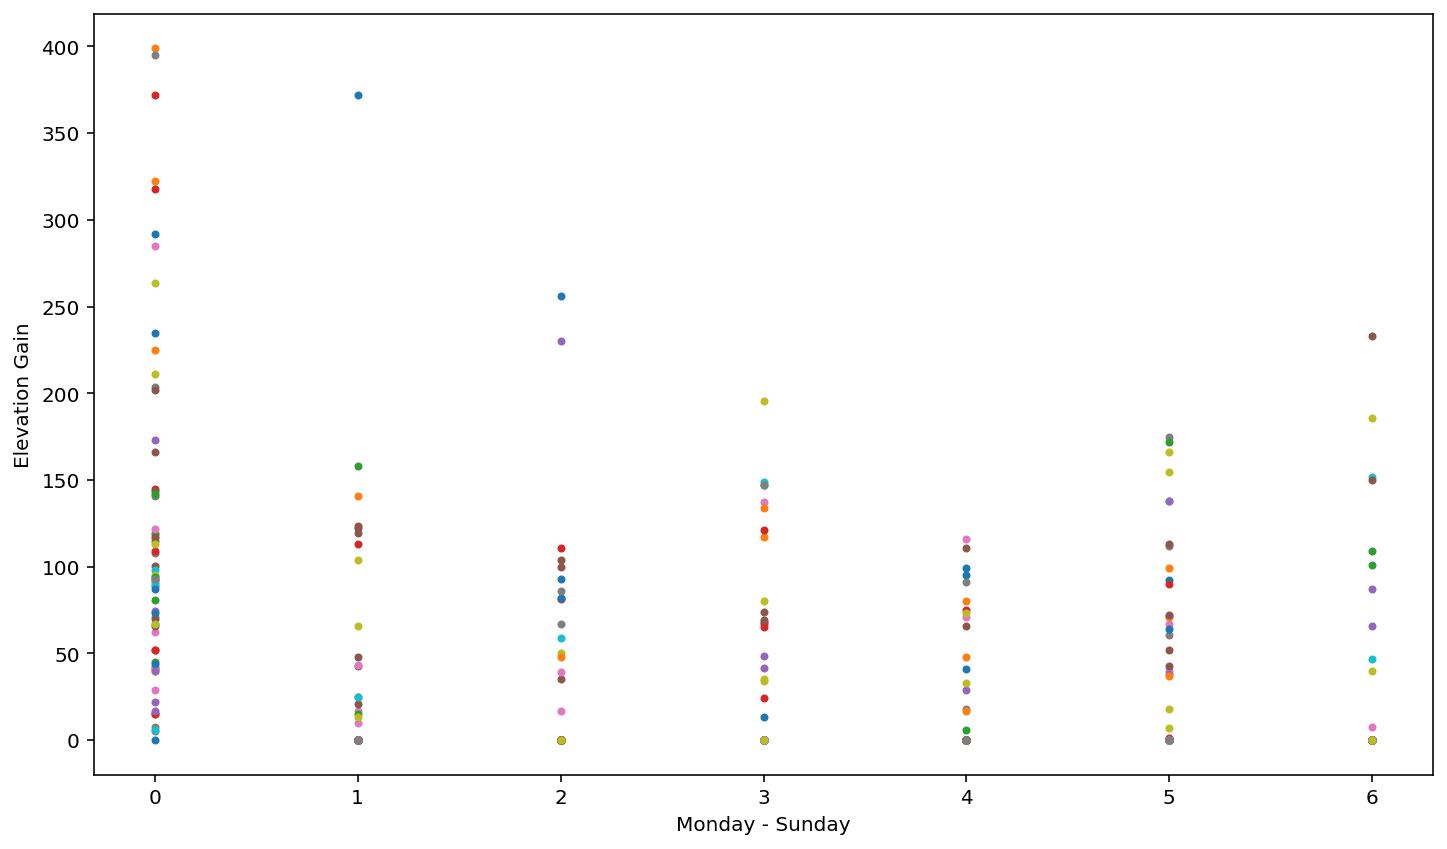

In [9]:
class Log:
    '''weeks list'''
    def __init__(self, weeks):
        self.weeks = weeks
        
    def graph_thing(self, attribute):
        '''graphs all points using the fixed weeks'''
        for week in self.weeks:
            if len(week.runs) == 7:
                y = []
                for day in week.runs:
                    if day:
                        y.append(all_runs[attribute][day])
                    else:
                        y.append(0)

                plt.plot(range(7), y, '.')
        plt.xlabel('Monday - Sunday')
        plt.ylabel(attribute)

    def weekday_avg(self, attribute, off_days=True):
        '''finds daily averages throughout the week with a specific attribute'''
        avgs = []
        
        if off_days:
            totals = [0,0,0,0,0,0,0]
            for week in self.weeks:
                if len(week.runs) == 7:
                    for i in range(7):
                        if week.runs[i] and all_runs[attribute][week.runs[i]]:
                            totals[i] += all_runs[attribute][week.runs[i]]

            for total in totals:
                avgs.append(total/len(weeks))
                
        else:
            totals = {}
            for week in self.weeks:
                if len(week.runs) == 7:
                    for i in range(7):
                        if week.runs[i] and all_runs[attribute][week.runs[i]]:
                            if i in totals:
                                totals[i].append(all_runs[attribute][week.runs[i]])
                            else:
                                totals[i] = [all_runs[attribute][week.runs[i]]]

            for total in totals.values():
                avgs.append(sum(total)/len(total))

        return avgs
    
    def __str__(self):
        return f'{[week.runs for week in self.weeks]}'
            
log1 = Log(weeks)
print(log1.weekday_avg('Distance',off_days=False))
log1.graph_thing('Elevation Gain')

Distance: [10.626346153846155, 6.3335, 7.269230769230769, 7.358888888888889, 7.258999999999999, 7.6890909090909085, 6.28]
[10.046727272727274, 2.3030909090909093, 2.4083636363636365, 2.639636363636363, 1.9410909090909092, 3.4363636363636365, 1.5378181818181818]
Moving Time: [3224.294117647059, 1965.8947368421052, 2116.8260869565215, 2079.722222222222, 2036.7777777777778, 2205.0, 2092.315789473684]
[2989.8, 679.1272727272727, 680.6363636363636, 666.5818181818182, 722.8, 885.2181818181818, 521.1818181818181]
Average Speed: [3.5893516587276086, 3.1996559262275697, 3.205134391784668, 3.2472801208496094, 3.200505256652832, 3.294900165663825, 3.402576510111491]
[3.3283079017292367, 0.9279754118485884, 0.9446633078835227, 1.1638200933283025, 1.078330963308161, 1.223778585954146, 1.1635112459009345]
Elevation Gain: [nan, 83.81528820711024, 72.70951882275668, 78.46847897484189, 63.44652960035536, 65.44372701644897, 77.64077700887408]
[nan, 25.906543627652255, 21.41794702356512, 29.9606919722123

{'Average Speed': 112.7900711977245,
 'Moving Time': 140.6226696495153,
 'Distance': 146.90104371027232,
 'Elevation Gain': nan}

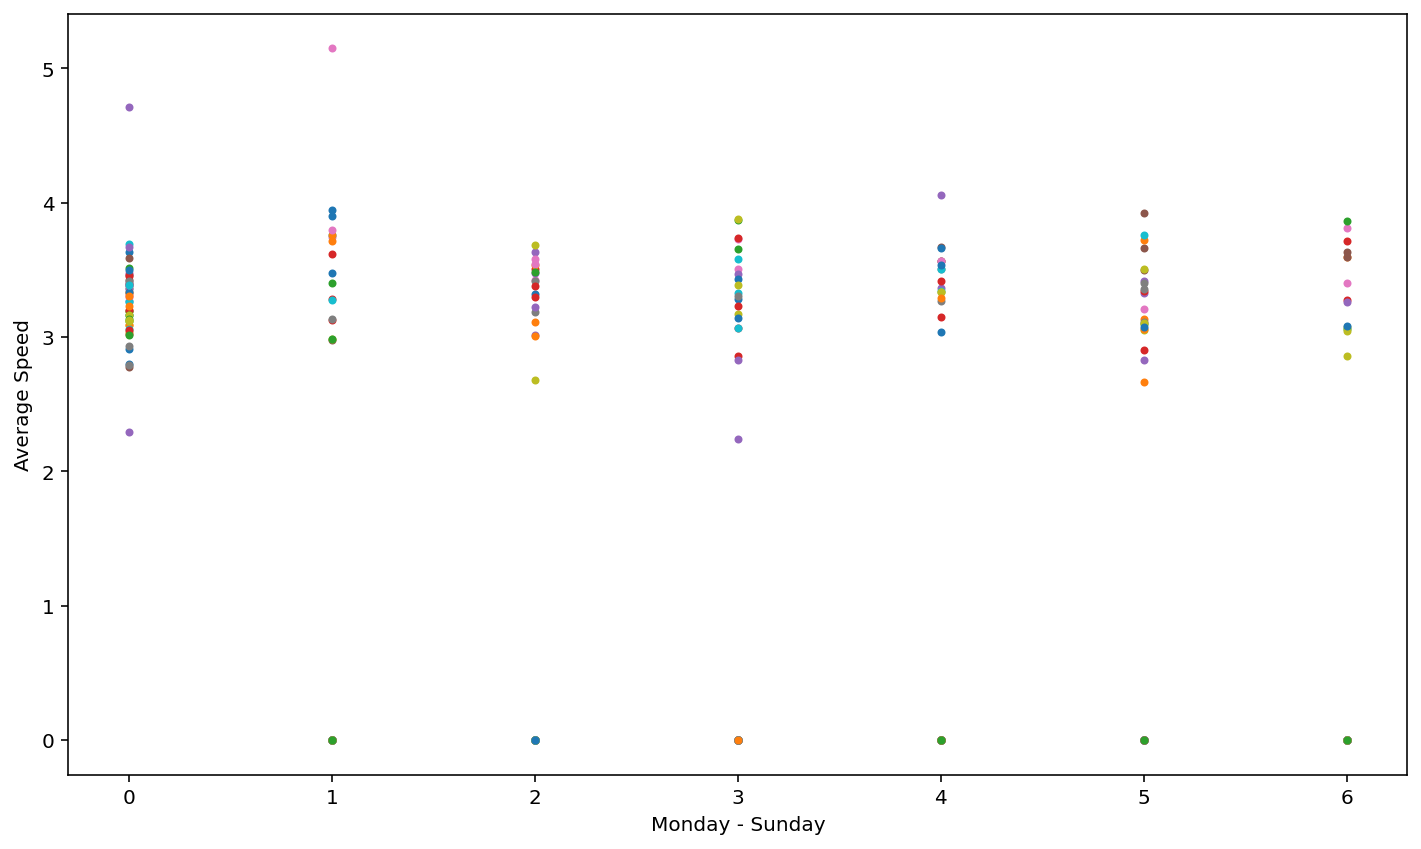

In [13]:
attributes = ['Distance', 'Moving Time', 'Average Speed', 'Elevation Gain']
options = []
for attribute in attributes:
    weeks = []

    for week in all_runs.groupby('week'):
        w = Week(list(week[1].index))
        w.setStart(w.getPeak(attribute)[1])
        if len(w.runs) > 1:
            w.fillWeek()
            weeks.append(w)

    log = Log(weeks)
    print(f'{attribute}: {log.weekday_avg(attribute,off_days=False)}\n{log.weekday_avg(attribute)}')
    options.append((log.weekday_avg(attribute), attribute))

log.graph_thing(attributes[2])


def percentdiff(x,y):
    '''calculates percentage difference between two numbers'''
    if x==y:
        return 0
    else:
        return (100*(abs(x-y)/((x+y)/2)))

    
diffs = {}

for op in options:
    op[0].sort()
    diffs[op[1]] = percentdiff(op[0][0], op[0][-1])

diffs = dict(sorted(diffs.items(), key=lambda item: item[1]))
diffs

12.1 miles at 7:44 pace for 93:36 minutes.
0.3 miles at 7:40 pace for 2:18 minutes.
5.4 miles at 7:43 pace for 41:42 minutes.
5.9 miles at 7:42 pace for 45:30 minutes.
5.3 miles at 7:47 pace for 41:18 minutes.
7.7 miles at 7:43 pace for 59:30 minutes.
Rest day


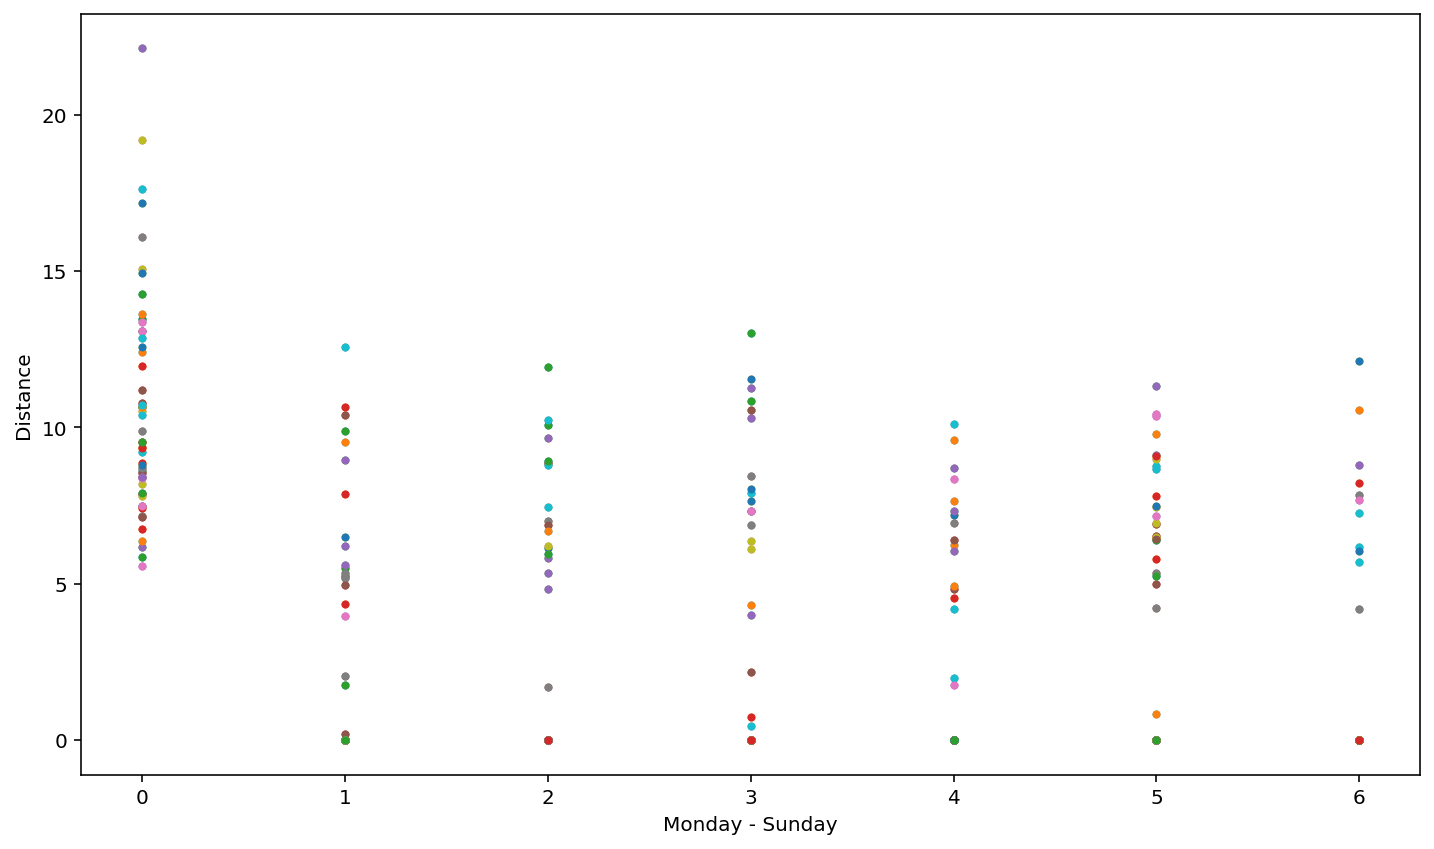

In [11]:
weeks = []

for week in all_runs.groupby('week'):
    w = Week(list(week[1].index))
    w.setStart(w.getPeak('Distance')[1])
    if len(w.runs) > 1:
        w.fillWeek()
        weeks.append(w)

log = Log(weeks)

def multiply(attribute):
    '''finds that factor multiply the base_runs by'''
    multipliers = []

    rest = log.weekday_avg('Distance',off_days=False)
    rest.sort()

    for i, kilometers in enumerate(log.weekday_avg('Distance',off_days=False)):
        if i == 0:
            multipliers.append(kilometers*.8 - rest[0])
        else:
            multipliers.append(kilometers - rest[0])

    log.graph_thing('Distance')
    return multipliers



def base_run(attribute):
    '''finds the next 7 days on the line of trajectory'''
    x = [int(i.strftime('%j'))+((int(i.strftime('%Y'))-2020)*365) for i in all_runs['Activity Date']]
    y = list(all_runs[attribute])
    a, b = np.polyfit(x, y, 1)
    
    baseweek = []
    for i in range(7):
        mydate = ((int(all_runs['week'][len(all_runs['week'])-1].split(' ')[0])-2020)*52+int(all_runs['week'][len(all_runs['week'])-1].split(' ')[1])+1)*7+i
        baseweek.append(a*(mydate)+b)
        
    return baseweek


def suggest(attribute, convert=1):
    '''puts multiply and base_run together'''
    suggestions = []
    
    for base, multi in zip(base_run(attribute), multiply(attribute)):
        suggestions.append(round(base*multi*convert, 1))
        
    return suggestions


def dectosec(number):
    '''turns secimal into a time'''
    if len(str(number).split('.')) > 1:
        if len(str(number).split('.')[1]) == 1:
            dec = f"{str(number).split('.')[1]}0"
        else:
            dec = str(number).split('.')[1]

        return f"{str(number).split('.')[0]}:{int(60*(int(dec)/100))}"
    else:
        return '0:00'

        

for d, t in zip(suggest('Distance', 0.621371),suggest('Moving Time', 1/60)):
    if d:
        print(f'{d} miles at {dectosec(round(t/d, 2))} pace for {dectosec(t)} minutes.')
    else:
        print('Rest day')

In [12]:
all_runs

,Activity ID,Activity Date,Activity Type,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Activity Private Note,Activity Gear,Filename,...,Newly Explored Distance,Newly Explored Dirt Distance,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,week
0,7698835652,2022-08-25 04:31:29,Run,743,2.27,NaN,NaN,NaN,NaN,activities/7698835652.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022 34
1,8146369281,2022-11-20 08:12:07,Run,489,1.68,NaN,NaN,NaN,NaN,activities/8146369281.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022 46
2,8164065980,2022-11-24 08:33:42,Run,481,1.68,NaN,NaN,NaN,NaN,activities/8164065980.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022 47
3,8207833156,2022-12-04 06:26:38,Run,1350,4.20,NaN,NaN,NaN,NaN,activities/8207833156.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022 48
4,8232903442,2022-12-10 07:06:52,Run,1219,3.71,NaN,NaN,NaN,NaN,activities/8232903442.gpx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022 49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,11529042773,2024-05-29 10:42:16,Run,3267,8.44,NaN,NaN,NaN,NaN,activities/12306834785.fit.gz,...,NaN,NaN,NaN,6568.0,NaN,NaN,468.0,229.0,3.430631,2024 22
204,11543386850,2024-05-31 10:35:59,Run,1790,4.22,NaN,NaN,NaN,NaN,activities/12321608539.fit.gz,...,NaN,NaN,NaN,3182.0,NaN,NaN,220.0,211.0,3.455234,2024 22
205,11543386867,2024-05-30 10:33:12,Run,4216,6.93,NaN,NaN,NaN,NaN,activities/12321608543.fit.gz,...,NaN,NaN,NaN,4786.0,NaN,NaN,388.0,189.0,3.529697,2024 22
206,11558774328,2024-06-02 06:26:08,Run,3481,9.89,NaN,NaN,NaN,NaN,activities/12337484885.fit.gz,...,NaN,NaN,NaN,7446.0,NaN,NaN,552.0,239.0,3.674387,2024 22
